<h1>Task 1: Dataset Selection and Preparation (20 Marks)</h1>

In [37]:
import pandas as pd

# Load dataset
df = pd.read_csv('social_media_engagement1.csv')

# Shows column names, non-null counts, and data types
df.info()

# Statistical summary for numeric columns
df.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   post_id          100 non-null    int64 
 1   platform         100 non-null    object
 2   post_type        100 non-null    object
 3   post_time        100 non-null    object
 4   likes            100 non-null    int64 
 5   comments         100 non-null    int64 
 6   shares           100 non-null    int64 
 7   post_day         100 non-null    object
 8   sentiment_score  100 non-null    object
dtypes: int64(4), object(5)
memory usage: 7.2+ KB


,post_id,likes,comments,shares
count,100.000000,100.000000,100.00000,100.000000
mean,50.500000,2381.810000,202.66000,415.650000
std,29.011492,1632.573284,138.84067,283.877601
min,1.000000,15.000000,10.00000,16.000000
25%,25.750000,895.750000,89.75000,183.000000
50%,50.500000,2220.000000,171.00000,356.500000
75%,75.250000,3593.250000,299.00000,689.500000
max,100.000000,5000.000000,500.00000,993.000000


In [38]:
# Check missing values
print("Missing values per column:\n", df.isnull().sum())

# Handle missing values for each column
# post_id -> identifier, replace missing with empty string
df['post_id'] = df['post_id'].fillna('')

# platform -> categorical, replace missing with 'unknown'
df['platform'] = df['platform'].fillna('unknown')

# post_type -> categorical, replace missing with 'unknown'
df['post_type'] = df['post_type'].fillna('unknown')

# post_time -> datetime-like string, replace missing with placeholder date
df['post_time'] = pd.to_datetime(df['post_time'], errors='coerce')
df['post_time'] = df['post_time'].fillna(pd.Timestamp('1970-01-01 00:00:00'))

# likes -> numeric, replace missing with 0
df['likes'] = df['likes'].fillna(0)

# comments -> numeric, replace missing with 0
df['comments'] = df['comments'].fillna(0)

# shares -> numeric, replace missing with 0
df['shares'] = df['shares'].fillna(0)

# post_day -> categorical, replace missing with 'unknown'
df['post_day'] = df['post_day'].fillna('unknown')

# sentiment_score -> categorical, replace missing with 'unknown'
df['sentiment_score'] = df['sentiment_score'].fillna('unknown')

Missing values per column:
 post_id            0
platform           0
post_type          0
post_time          0
likes              0
comments           0
shares             0
post_day           0
sentiment_score    0
dtype: int64


<h3>I chose to use the fillna() for handling the missing values because it keeps all rows in the dataset while replacing missing values with sensible defaults (e.g., empty string for text, 0 for numbers). This prevents errors during analysis or model training and avoids losing useful information by dropping rows.</h3>

<h1>Task 2: Data Aggregation and Analysis (20 Marks)</h1>

In [39]:
# 1. Total posts per platform
# This counts how many posts were made on each social media platform which helps identify which platforms are the most active or most used by users.
posts_per_platform = df['platform'].value_counts()
print("\n1. Total posts per platform:\n", posts_per_platform)

# 2. Average engagement (likes, comments, shares) by post type
# This calculates the mean number of likes, comments, and shares for each post type to reveal which type of content (e.g., photo, video, text) 
# generally performs better.
avg_engagement_by_type = df.groupby('post_type')[['likes', 'comments', 'shares']].mean().round(2)
print("\n2. Average engagement by post type:\n", avg_engagement_by_type)

# 3. Sentiment distribution across platforms
# It provides insight into how audiences feel about content on different platforms.
sentiment_distribution = df.groupby(['platform', 'sentiment_score']).size().unstack(fill_value=0)
print("\n3. Sentiment distribution across platforms:\n", sentiment_distribution)

# 4. Top 3 post types by average shares
# It helps highlight which types of content are more likely to be shared and potentially go viral.
top_shared_types = df.groupby('post_type')['shares'].mean().round(2).nlargest(3)
print("\n4. Top 3 post types by average shares:\n", top_shared_types)

# 5. Average engagement by day of the week
# Identifies which days generate higher user interaction to identify the best posting times. 
avg_engagement_by_day = df.groupby('post_day')[['likes', 'comments', 'shares']].mean().round(2)
print("\n5. Average engagement by day:\n", avg_engagement_by_day)



1. Total posts per platform:
 platform
Instagram    36
Facebook     32
Twitter      32
Name: count, dtype: int64

2. Average engagement by post type:
              likes  comments  shares
post_type                           
carousel   2263.58    236.00  531.15
image      2032.76    197.18  371.53
poll       3061.08    214.54  470.77
text       1815.29    138.38  274.95
video      2906.78    221.00  415.00

3. Sentiment distribution across platforms:
 sentiment_score  negative  neutral  positive
platform                                    
Facebook               11        9        12
Instagram              14        8        14
Twitter                 2       10        20

4. Top 3 post types by average shares:
 post_type
carousel    531.15
poll        470.77
video       415.00
Name: shares, dtype: float64

5. Average engagement by day:
              likes  comments  shares
post_day                            
Friday     2655.56    232.31  428.81
Monday     1666.00    154.45  388.00
S

<h1>Task 3: Sentiment Analysis with Hugging Face (30 Marks)</h1>

In [21]:
from transformers import pipeline

# Load the dataset
df = pd.read_csv("social_media_engagement1.csv")

# 1. Create a sentiment analysis pipeline using the Hugging Face model
# nlptown/bert-base-multilingual-uncased-sentiment outputs ratings 1–5 (1 = very negative, 5 = very positive)
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 2. Apply the pipeline to the 'post_type' text column (or replace with your text column if different)
# The model returns labels like "1 star", "5 stars". We'll extract the numeric rating.
def get_sentiment_score(text):
    result = sentiment_pipeline(text[:512])[0]  # limit to 512 chars
    label = result["label"]  # e.g., "4 stars"
    score = int(label.split()[0])  # extract numeric rating
    return score

# Create a new column with sentiment scores
df["predicted_sentiment"] = df["post_type"].astype(str).apply(get_sentiment_score)

# 3. Find top 5 highest and lowest sentiment scores
top5 = df.sort_values("predicted_sentiment", ascending=False).head(5).reset_index(drop=True)
print("Top 5 Positive Posts:")
print(top5[["post_id", "post_type", "predicted_sentiment"]])

# Bottom 5 negative posts
bottom5 = df.sort_values("predicted_sentiment", ascending=True).head(5).reset_index(drop=True)
print("\nBottom 5 Negative Posts:")
print(bottom5[["post_id", "post_type", "predicted_sentiment"]])

Device set to use cpu


Top 5 Positive Posts:
   post_id post_type  predicted_sentiment
0        2  carousel                    5
1       15  carousel                    5
2       10  carousel                    5
3        6  carousel                    5
4       30  carousel                    5

Bottom 5 Negative Posts:
   post_id post_type  predicted_sentiment
0        1     image                    4
1        3      poll                    4
2        4     image                    4
3        5     video                    4
4        8      text                    4


<h1>Task 4: Interactive Visualisation with Plotly (20 Marks)</h1>

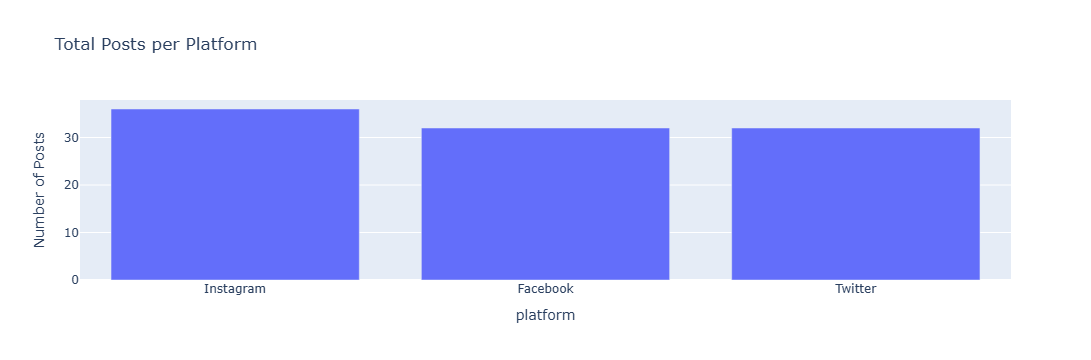

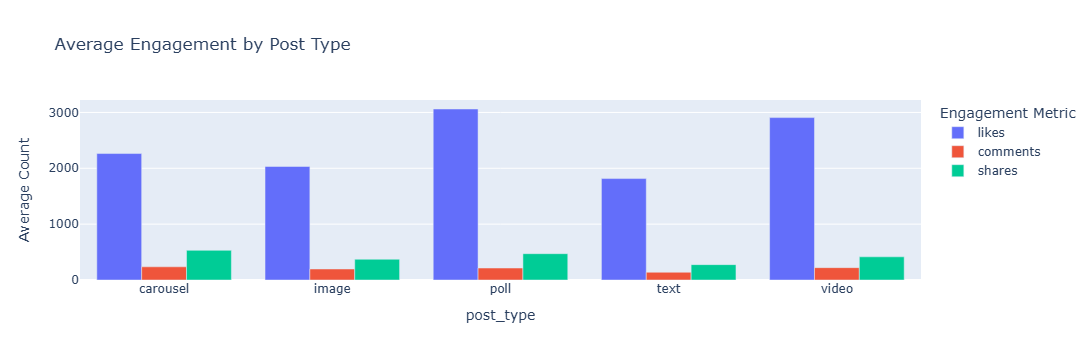

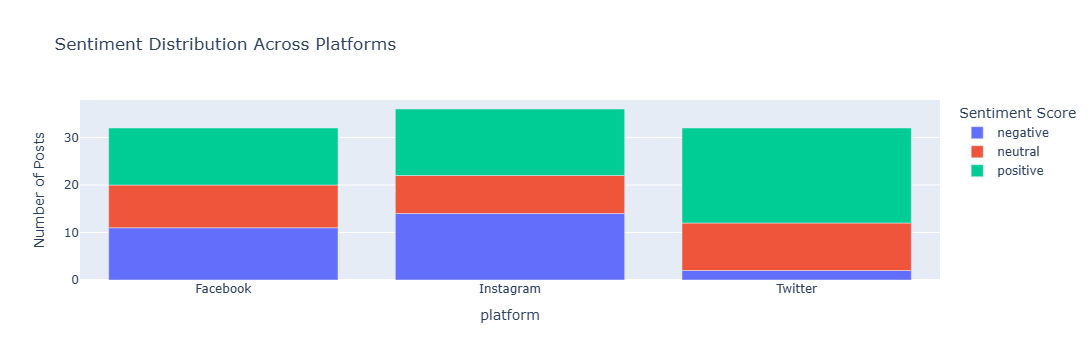

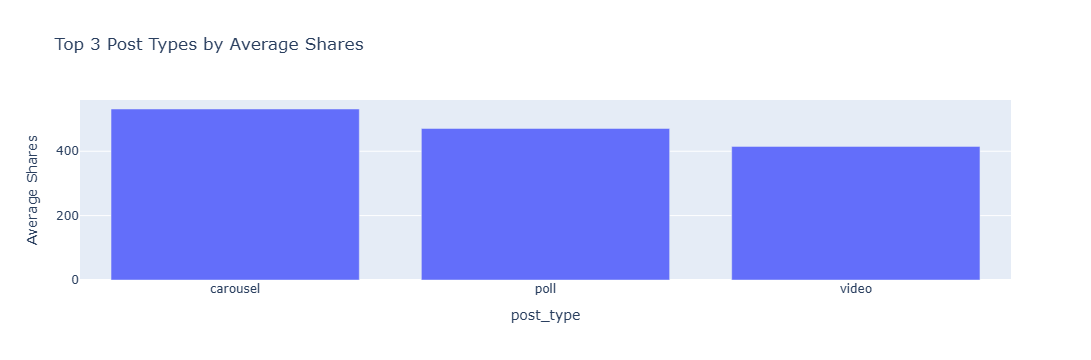

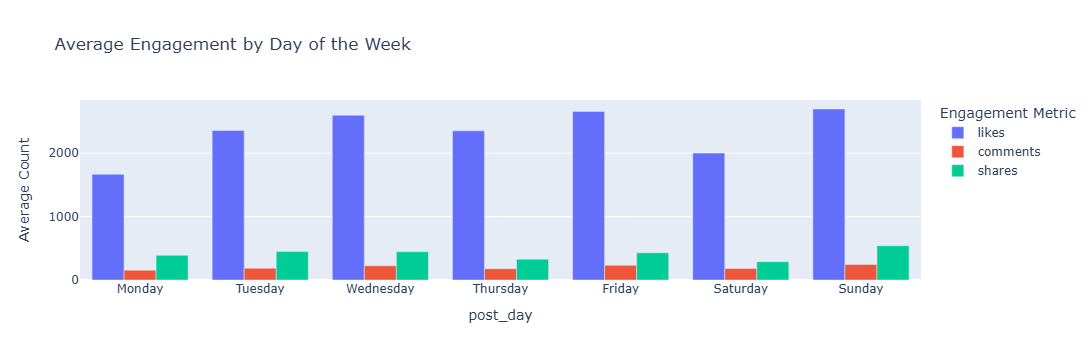

In [31]:
import plotly.express as px

#Visualizing the data aggregration in Task 2

# 1. Total posts per platform (Bar chart)
posts_per_platform = df['platform'].value_counts().reset_index()
posts_per_platform.columns = ['platform', 'post_count']
fig1 = px.bar(
    posts_per_platform, 
    x='platform', 
    y='post_count', 
    title='Total Posts per Platform',
    labels={'post_count': 'Number of Posts'}
)
fig1.show()

# 2. Average engagement (likes, comments, shares) by post type (Grouped Bar chart)
avg_engagement_by_type = df.groupby('post_type', observed=False)[['likes', 'comments', 'shares']].mean().round(2).reset_index()
fig2 = px.bar(
    avg_engagement_by_type, 
    x='post_type', 
    y=['likes', 'comments', 'shares'], 
    title='Average Engagement by Post Type',
    barmode='group',
    labels={'value': 'Average Count', 'variable': 'Engagement Metric'}
)
fig2.show()

# 3. Sentiment distribution across platforms (Stacked Bar chart)
sentiment_distribution = df.groupby(["platform", "sentiment_score"], observed=False).size().unstack(fill_value=0).reset_index()
sentiment_distribution_melted = sentiment_distribution.melt(id_vars=['platform'], var_name='sentiment_score', value_name='count')
fig3 = px.bar(
    sentiment_distribution_melted, 
    x='platform', 
    y='count', 
    color='sentiment_score', 
    title='Sentiment Distribution Across Platforms',
    labels={'count': 'Number of Posts', 'sentiment_score': 'Sentiment Score'}
)
fig3.show()

# 4. Top 3 post types by average shares (Bar chart)
top_shared_types = df.groupby("post_type", observed=False)["shares"].mean().round(2).nlargest(3).reset_index()
top_shared_types.columns = ['post_type', 'average_shares']
fig4 = px.bar(
    top_shared_types, 
    x='post_type', 
    y='average_shares', 
    title='Top 3 Post Types by Average Shares',
    labels={'average_shares': 'Average Shares'}
)
fig4.show()

# 5. Average engagement by day of the week (Grouped Bar chart)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['post_day'] = pd.Categorical(df['post_day'], categories=day_order, ordered=True)
avg_engagement_by_day = df.groupby("post_day", observed=False)[["likes", "comments", "shares"]].mean().round(2).reset_index()
fig5 = px.bar(
    avg_engagement_by_day, 
    x='post_day', 
    y=['likes', 'comments', 'shares'], 
    title='Average Engagement by Day of the Week',
    barmode='group',
    labels={'value': 'Average Count', 'variable': 'Engagement Metric'}
)
fig5.show()